 # Interval-based approximation analysis

In [ ]:
pip install tenseal

In [ ]:
import tenseal as ts
from time import time
import torch
from torchvision import transforms
from random import randint
import pickle
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from typing import Dict
from numpy import linalg as LA
from scipy.stats import chisquare

#  CKKS Homomorphic scheme




In [ ]:
poly_mod_degree = 8192

bits_scale = 26
coeff_mod_bit_sizes = [31, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, bits_scale, 31]

ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
ctx.global_scale = 2 ** bits_scale
ctx.generate_galois_keys()

plain1 = ts.plain_tensor([1])
plain2 = ts.plain_tensor([0.5])

encrypted_tensor1 = ts.ckks_tensor(ctx, plain1)
encrypted_tensor2 = ts.ckks_tensor(ctx, plain2)

def decrypt(enc):
    return enc.decrypt().tolist()

result = encrypted_tensor1 - encrypted_tensor2
print("Plain equivalent: {} + {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

result = encrypted_tensor1 * encrypted_tensor2
print("Plain equivalent: {} * {}\nDecrypted result: {}.".format(plain1.tolist(), plain2.tolist(), decrypt(result)))

Plain equivalent: [1.0] + [0.5]
Decrypted result: [0.5000647198162118].
Plain equivalent: [1.0] * [0.5]
Decrypted result: [0.5004134691855496].


#  Comparison function

In [ ]:
def sign(x):
  if x > 0:
    return 1
  elif x < 0:
    return -1
  else:
    return 0

def comparison(enc_x):
    return enc_x.polyval([0.5, 0.197, 0, -0.004])

x = np.linspace(-1,1,1000)
y_mil = np.sign(x)

#  Least squares

Least squares
Polynomial generation (Average of 30 executions): 0.6136863377888998 ms
Polynomial generation (only the last one): 0.5476474761962891 ms
      9             8         7             6         5             4
48.9 x - 6.103e-13 x - 119.4 x + 2.088e-13 x + 103.4 x - 1.838e-14 x
          3             2
 - 38.38 x + 3.324e-13 x + 6.655 x - 7.72e-14


Polynomial evaluation (Average of 30 executions): 143.281699385325113 ms
Polynomial evaluation (only the last one): 141.79251670837402 ms
[0.5000647198162118]
[0.8280097310521407]


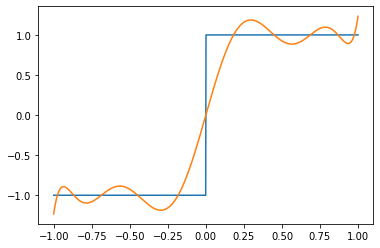

r_squared: 0.9394411972182359
Chi_squared: 9.602985073797754e-12
 
1- norm: 152.20077071671045
2- norm: 7.781953660988003
Infinity- norm: 0.9933380431438049
 
1- norm: 15.220077071671046
2- norm: 24.608698214607898
Infinity- norm: 99.33380431438049


In [ ]:
print("Least squares")
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_mil)

t_end = 0
t_start = 0
suma_temp = 0
for teh in range(30):
  t_start = time()
  p = np.polyfit(x, y_mil, 9)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial generation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial generation (only the last one): {} ms".format((t_end - t_start) * 1000))

ax = fig.add_subplot(111)
poly = [np.polyval(p, i) for i in x]

ax.plot(x, poly)

p_test = np.poly1d(p)
print(p_test)

# Evaluation of the sign function over ciphertexts
resta = encrypted_tensor1 - encrypted_tensor2

suma_temp = 0
t_end = 0
t_start = 0

for teh in range(30):
  t_start = time()
  evaluacion = resta.polyval(p_test)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial evaluation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial evaluation (only the last one): {} ms".format((t_end - t_start) * 1000))

print(decrypt(resta))
print(decrypt(evaluacion))
plt.show()

## R Square measure
correlation_matrix = np.corrcoef(y_mil, poly)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print("r_squared: {}".format(r_squared))

## Norms
vector = y_mil - poly
k=0
for jj in vector:
  if jj < 0:
    vector[k]=vector[k]*-1
  k=k+1

print("1- norm: {}".format(LA.norm(vector, 1)))
print("2- norm: {}".format(LA.norm(vector, 2)))
print("Infinity- norm: {}".format(LA.norm(vector, np.inf)))
print(" ")
##Relative norms
relative_one = LA.norm(vector, 1)/LA.norm(y_mil, 1)
print("1- norm: {}".format(relative_one*100))
relative_two = LA.norm(vector, 2)/LA.norm(y_mil, 2)
print("2- norm: {}".format(relative_two*100))
relative_inf = LA.norm(vector, np.inf)/LA.norm(y_mil, np.inf)
print("Infinity- norm: {}".format(relative_inf*100))

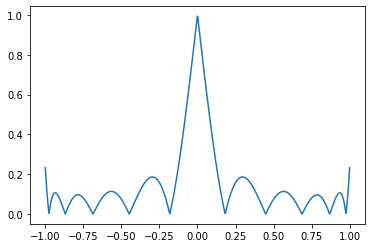

In [ ]:
#Least-squares: Analysis of approximation error for each component i
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(-1,1,1000), vector)

intervals = np.arange(0, 0.51, 0.01)

for epsilon in intervals:
  epsilon_negative = -1 * epsilon
  new_x = []

  for x_i in x:
    if x_i < 0:
      if x_i <= epsilon_negative:
        new_x.append(x_i)
    else:
      if x_i >= epsilon:
        new_x.append(x_i)

  poly_temp = [np.polyval(p, i) for i in new_x]
  y_temp = np.sign(new_x)

  correlation_matrix = np.corrcoef(y_temp, poly_temp)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  #print(r_squared)

  vector_temp = y_temp - poly_temp
  k=0
  for jj in vector_temp:
    if jj < 0:
      vector_temp[k]=vector_temp[k]*-1
    k=k+1

  l_one = LA.norm(vector_temp, 1)/LA.norm(y_mil, 1)
  #print(l_one*100)

  l_two = LA.norm(vector_temp, 2)/LA.norm(y_mil, 2)
  #print(l_two*100)

# Composition


Polynomial composition
Polynomial generation (Average of 30 executions): 0.4245846684773763 ms
Polynomial generation (only the last one): 0.3262592315673828 ms
 
Polynomial evaluation (Average of 30 executions): 99.02146154785156 ms
Polynomial evaluation (only the last one): 92.65327453613281 ms
[0.5000647198162118]
[0.9742790455206864]
       9         7         5         3
1.169 x - 5.485 x + 8.581 x - 6.465 x + 3.114 x
r_squared: 0.8919168937206017
Chi_squared: 1.4210854715202004e-14
 
1- norm: 197.7150586772188
2- norm: 10.820838467601657
Infinity- norm: 0.9968826312971201
 
1- norm: 19.771505867721878
2- norm: 34.21849575038736
Infinity- norm: 99.68826312971201


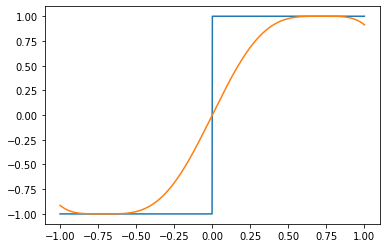

In [ ]:
print("Polynomial composition")

f = np.poly1d([(-1/2), 0, (3/2),0])
g = np.poly1d([(-1359/1024), 0, (2126/1024),0])

t_end = 0
t_start = 0
suma_temp = 0
for teh in range(30):
  t_start = time()
  compositon = f(g)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial generation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial generation (only the last one): {} ms".format((t_end - t_start) * 1000))
print(" ")

p_test_composition = np.poly1d(compositon)

# Evaluation of the sign function over ciphertexts by using polynomial composition
resta = encrypted_tensor1 - encrypted_tensor2

suma_temp = 0
t_end = 0
t_start = 0
for teh in range(30):
  t_start = time()
  evaluacion = resta.polyval(p_test_composition)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial evaluation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial evaluation (only the last one): {} ms".format((t_end - t_start) * 1000))

print(decrypt(resta))
print(decrypt(evaluacion))
print(p_test_composition)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_mil)

ax = fig.add_subplot(111)
poly = [np.polyval(p_test_composition, i) for i in x]

ax.plot(x, poly)

## R Square measure
correlation_matrix = np.corrcoef(np.sign(x), poly)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print("r_squared: {}".format(r_squared))

## Chi Square measure
chi = chisquare(poly, f_exp=y_mil)
print("Chi_squared: {}".format(chi[0]))
print(" ")

## Norms
vector = y_mil - poly
k=0
for jj in vector:
  if jj < 0:
    vector[k]=vector[k]*-1
  k=k+1

print("1- norm: {}".format(LA.norm(vector, 1)))
print("2- norm: {}".format(LA.norm(vector, 2)))
print("Infinity- norm: {}".format(LA.norm(vector, np.inf)))

print(" ")

relative_one = LA.norm(vector, 1)/LA.norm(y_mil, 1)
print("1- norm: {}".format(relative_one*100))
relative_two = LA.norm(vector, 2)/LA.norm(y_mil, 2)
print("2- norm: {}".format(relative_two*100))
relative_inf = LA.norm(vector, np.inf)/LA.norm(y_mil, np.inf)
print("Infinity- norm: {}".format(relative_inf*100))

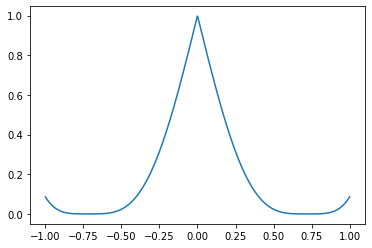

In [ ]:
#Composition: Analysis of approximation error for each component i
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(-1,1,1000), vector)

intervals = np.arange(0, 0.51, 0.01)

for epsilon in intervals:
  epsilon_negative = -1 * epsilon
  new_x = []

  for x_i in x:
    if x_i < 0:
      if x_i <= epsilon_negative:
        new_x.append(x_i)
    else:
      if x_i >= epsilon:
        new_x.append(x_i)

  poly_temp = [np.polyval(p_test_composition, i) for i in new_x]
  y_temp = np.sign(new_x)

  correlation_matrix = np.corrcoef(y_temp, poly_temp)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  #print(r_squared)

  vector_temp = y_temp - poly_temp
  k=0
  for jj in vector_temp:
    if jj < 0:
      vector_temp[k]=vector_temp[k]*-1
    k=k+1

  l_one = LA.norm(vector_temp, 1)/LA.norm(y_mil, 1)
  #print(l_one*100)

  l_two = LA.norm(vector_temp, 2)/LA.norm(y_mil, 2)
  #print(l_two*100)

# Newton-Raphson

Newton-Raphson
Polynomial generation (Average of 30 executions): 0.38408167521158853 ms
Polynomial generation (only the last one): 0.32649765014648438 ms
 
Polynomial evaluation (Average of 30 executions): 98.91054871877034 ms
Polynomial evaluation (only the last one): 96.9545841217041 ms
[0.5000647198162118]
[0.8689849802368875]
        9          7         5         3
0.0625 x - 0.5625 x + 1.688 x - 2.438 x + 2.25 x
r_squared: 0.8558868571811582
1- norm: 266.9199371243394
2- norm: 12.717470536481184
Infinity- norm: 0.9977477501925732
Percents: 
1- norm: 26.69199371243394
2- norm: 40.216172971364024
Infinity- norm: 99.77477501925732


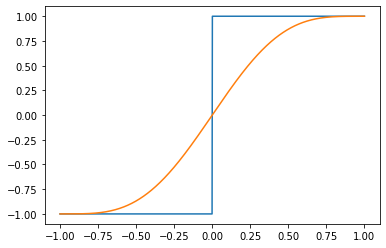

In [ ]:
print("Newton-Raphson")
ff = np.poly1d([(-1/2), 0, (3/2),0])

suma_temp = 0
t_end = 0
t_start = 0
for teh in range(30):
  t_start = time()
  f_newton = ff(ff)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial generation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial generation (only the last one): {} ms".format((t_end - t_start) * 1000))
print(" ")

# Evaluation of the sign function over ciphertexts by using Newton-Raphson polynomial
resta_newton = encrypted_tensor1 - encrypted_tensor2

suma_temp = 0
t_end = 0
t_start = 0
for teh in range(30):
  t_start = time()
  evaluacion_newton = resta_newton.polyval(f_newton)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial evaluation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial evaluation (only the last one): {} ms".format((t_end - t_start) * 1000))

print(decrypt(resta_newton))
print(decrypt(evaluacion_newton))
print(f_newton)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_mil)

ax = fig.add_subplot(111)
poly_newton = [np.polyval(f_newton, i) for i in x]

ax.plot(x, poly_newton)

## R Square measure
correlation_matrix = np.corrcoef(np.sign(x), poly_newton)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print("r_squared: {}".format(r_squared))

## Norms
vector = y_mil - poly_newton

k=0
for jj in vector:
  if jj < 0:
    vector[k]=vector[k]*-1
  k=k+1
print("1- norm: {}".format(LA.norm(vector, 1)))
print("2- norm: {}".format(LA.norm(vector, 2)))
print("Infinity- norm: {}".format(LA.norm(vector, np.inf)))

##Relative norms
print("Percents: ")
relative_one = LA.norm(vector, 1)/LA.norm(y_mil, 1)
print("1- norm: {}".format(relative_one*100))
relative_two = LA.norm(vector, 2)/LA.norm(y_mil, 2)
print("2- norm: {}".format(relative_two*100))
relative_inf = LA.norm(vector, np.inf)/LA.norm(y_mil, np.inf)
print("Infinity- norm: {}".format(relative_inf*100))

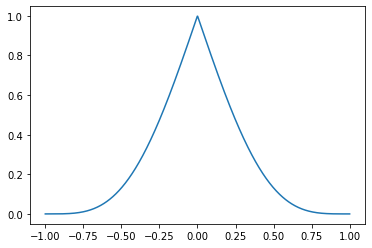

In [ ]:
#Newton-Raphson: Interval-based analysis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(-1,1,1000), vector)

intervals = np.arange(0, 0.51, 0.01)

for epsilon in intervals:
  epsilon_negative = -1 * epsilon
  new_x = []

  for x_i in x:
    if x_i < 0:
      if x_i <= epsilon_negative:
        new_x.append(x_i)
    else:
      if x_i >= epsilon:
        new_x.append(x_i)

  poly_temp = [np.polyval(f_newton, i) for i in new_x]
  y_temp = np.sign(new_x)

  correlation_matrix = np.corrcoef(y_temp, poly_temp)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  #print(r_squared)

  vector_temp = y_temp - poly_temp
  k=0
  for jj in vector_temp:
    if jj < 0:
      vector_temp[k]=vector_temp[k]*-1
    k=k+1

  l_one = LA.norm(vector_temp, 1)/LA.norm(y_mil, 1)
  #print(l_one*100)

  l_two = LA.norm(vector_temp, 2)/LA.norm(y_mil, 2)
  #print(l_two*100)

# Chebyshev interpolation
NOTES:

*   The Chebyshev coefficients were calculated on Matlab based on http://www.chebfun.org/docs/guide/guide04.html

*   Once the x,y points and Chebyshev coefficients were generated, we measure the quality of the approximation.

Chebyshev
Polynomial generation (true value comes from Matlab): 0.56327598571777344 ms


Polynomial evaluation (Average of 30 executions): 121.6543912378947 ms
Polynomial evaluation (last one): 116.5468692779541 ms
[0.5000647198162118]
[0.592257469264571]
cheb([ 0.      1.2797  0.     -0.4444  0.      0.2901  0.     -0.2365  0.
  0.1111])
r_squared: 0.9347409510547436
1- norm: 165.25782235624996
2- norm: 8.12372466278632
Infinity- norm: 0.9932745087326672
Percents: 
1- norm: 16.525782235624998
2- norm: 25.68947301848808
Infinity- norm: 99.32745087326673


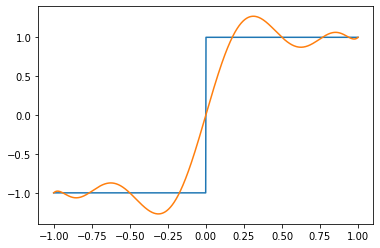

In [ ]:
print("Chebyshev")
from numpy.polynomial import Chebyshev
import pandas as pd

#We obtained the Chebyshev coefficients from Matlab
coefficients_chebyshev = [0, 1.2797, 0, -0.4444, 0, 0.2901 ,0, -0.2365, 0, 0.1111]

t_start = time()
get_new_serie = Chebyshev(coefficients_chebyshev)
t_end = time()
print("Polynomial generation (true value comes from Matlab): {} ms".format((t_end - t_start) * 1000))

#y points from chebyshev serie generated based on the coefficients (for measures)
y_data_chebyshev = get_new_serie(x)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x, y_mil)

ax = fig.add_subplot(111)
ax.plot(x, y_data_chebyshev)

# Evaluation of the sign function over ciphertexts by using
resta = encrypted_tensor1 - encrypted_tensor2

suma_temp = 0
t_end = 0
t_start = 0
for teh in range(30):
  t_start = time()
  evaluacion = resta.polyval(coefficients_chebyshev)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial evaluation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial evaluation (last one): {} ms".format((t_end - t_start) * 1000))

print(decrypt(resta))
print(decrypt(evaluacion))
print(get_new_serie)

## R Square measure
correlation_matrix = np.corrcoef(np.sign(x), y_data_chebyshev)
correlation_xy = correlation_matrix[0,1]
r_squared = correlation_xy**2
print("r_squared: {}".format(r_squared))

## Norms
vector = y_mil - y_data_chebyshev
k=0
for jj in vector:
  if jj < 0:
    vector[k]=vector[k]*-1
  k=k+1
print("1- norm: {}".format(LA.norm(vector, 1)))
print("2- norm: {}".format(LA.norm(vector, 2)))
print("Infinity- norm: {}".format(LA.norm(vector, np.inf)))

##Relative norms
print("Percents: ")
relative_one = LA.norm(vector, 1)/LA.norm(y_mil, 1)
print("1- norm: {}".format(relative_one*100))
relative_two = LA.norm(vector, 2)/LA.norm(y_mil, 2)
print("2- norm: {}".format(relative_two*100))
relative_inf = LA.norm(vector, np.inf)/LA.norm(y_mil, np.inf)
print("Infinity- norm: {}".format(relative_inf*100))

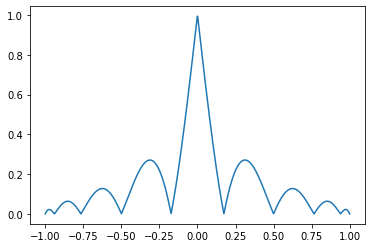

In [ ]:
#Chebyshev: Interval-based analysis
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.linspace(-1,1,1000), vector)

intervals = np.arange(0, 0.51, 0.01)

for epsilon in intervals:
  epsilon_negative = -1 * epsilon
  new_x = []

  for x_i in x:
    if x_i < 0:
      if x_i <= epsilon_negative:
        new_x.append(float(x_i))
    else:
      if x_i >= epsilon:
        new_x.append(float(x_i))

  new_x = np.array(new_x)
  poly_temp = get_new_serie(new_x)
  y_temp = np.sign(new_x)

  correlation_matrix = np.corrcoef(y_temp, poly_temp)
  correlation_xy = correlation_matrix[0,1]
  r_squared = correlation_xy**2
  #print(r_squared)

  vector_temp = y_temp - poly_temp
  k=0
  for jj in vector_temp:
    if jj < 0:
      vector_temp[k]=vector_temp[k]*-1
    k=k+1

  l_one = LA.norm(vector_temp, 1)/LA.norm(y_mil, 1)
  #print(l_one*100)

  l_two = LA.norm(vector_temp, 2)/LA.norm(y_mil, 2)
  #print(l_two*100)

# Fourier sequence

In [ ]:
pip install symfit

Polynomial generation (Average of 30 executions): 1.2649510828653972 ms
Polynomial generation (only the last one): 1.2159347534179688 ms
{y: a0 + a1*cos(w*x) + a2*cos(2*w*x) + a3*cos(3*w*x) + a4*cos(4*w*x) + a5*cos(5*w*x) + a6*cos(6*w*x) + a7*cos(7*w*x) + a8*cos(8*w*x) + a9*cos(9*w*x) + b1*sin(w*x) + b2*sin(2*w*x) + b3*sin(3*w*x) + b4*sin(4*w*x) + b5*sin(5*w*x) + b6*sin(6*w*x) + b7*sin(7*w*x) + b8*sin(8*w*x) + b9*sin(9*w*x)}

Parameter Value        Standard Deviation
a0        -3.150285e-11 5.565400e-03
a1        6.752556e-11 8.969899e-03
a2        7.212660e-11 8.898184e-03
a3        -6.231300e-11 8.782346e-03
a4        -8.628528e-11 8.627766e-03
a5        1.004699e-11 8.441686e-03
a6        -2.089302e-11 8.232883e-03
a7        -1.661747e-10 8.011244e-03
a8        -1.575189e-10 7.787202e-03
a9        1.469227e-11 7.571057e-03
b1        1.268359e+00 6.577004e-03
b2        9.695796e-03 6.633145e-03
b3        4.100476e-01 6.718367e-03
b4        1.884366e-02 6.821731e-03
b5        2.316042

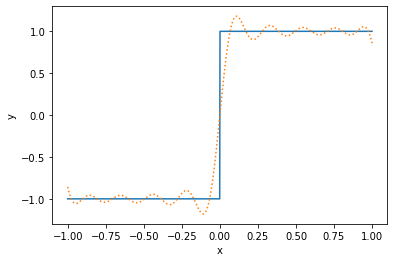

Polynomial evaluation (Average of 30 executions): 132.91284138743083 ms
Polynomial evaluation (only the last one): 133.93617630004883 ms
[0.5000647198162118]
[0.6991438996973299]
1- norm: 72.64519253746695
2- norm: 4.742416290421475
Infinity- norm: 0.9817867773558411
Percents: 
1- norm: 7.264519253746696
2- norm: 14.996837090418428
Infinity- norm: 98.1786777355841


In [ ]:
from symfit import parameters, variables, sin, cos, Fit

def fourier_series(x, f, n=0):
    """
    :param n: Order of the fourier series.
    :param x: Independent variable
    :param f: Frequency of the fourier series
    """

    a0, *cos_a = parameters(','.join(['a{}'.format(i) for i in range(0, n + 1)]))
    sin_b = parameters(','.join(['b{}'.format(i) for i in range(1, n + 1)]))

    series = a0 + sum(ai * cos(i * f * x) + bi * sin(i * f * x)
                     for i, (ai, bi) in enumerate(zip(cos_a, sin_b), start=1))
    return series

xdata = np.linspace(-1,1,1000)
ydata = y_mil

x, y = variables('x, y')
w, = parameters('w')
model_dict = {y: fourier_series(x, f=w, n=9)}

suma_temp = 0
t_end = 0
t_start = 0
for teh in range(30):
  t_start = time()
  fit = Fit(model_dict, x=xdata, y=ydata)
  t_end = time()
  suma_temp = suma_temp + ((t_end - t_start)*1000)

print("Polynomial generation (Average of 30 executions): {} ms".format(suma_temp/30))
print("Polynomial generation (only the last one): {} ms".format((t_end - t_start) * 1000))

fit_result = fit.execute()

print(model_dict)
print(fit_result)

plt.plot(xdata, ydata)
plt.plot(xdata, fit.model(x=xdata, **fit_result.params).y, ls=':')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Norms
vector = ydata - fit.model(x=xdata, **fit_result.params).y

k=0
for jj in vector:
  if jj < 0:
    vector[k]=vector[k]*-1
  k=k+1
print("1- norm: {}".format(LA.norm(vector, 1)))
print("2- norm: {}".format(LA.norm(vector, 2)))
print("Infinity- norm: {}".format(LA.norm(vector, np.inf)))

##Relative norms
print("Percents: ")
relative_one = LA.norm(vector, 1)/LA.norm(y_mil, 1)
print("1- norm: {}".format(relative_one*100))
relative_two = LA.norm(vector, 2)/LA.norm(y_mil, 2)
print("2- norm: {}".format(relative_two*100))
relative_inf = LA.norm(vector, np.inf)/LA.norm(y_mil, np.inf)
print("Infinity- norm: {}".format(relative_inf*100))

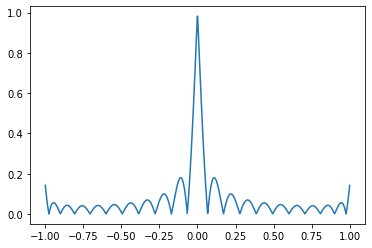

In [ ]:
#Fourier sequence: Interval-based analysis
fig = plt.figure()
ax = fig.add_subplot(111)
x_extra = np.linspace(-1,1,1000)
ax.plot(x_extra, vector)

intervals = np.arange(0, 0.51, 0.01)

for epsilon in intervals:
  epsilon_negative = -1 * epsilon
  new_x = []

  for x_i in x_extra:
    if x_i < 0:
      if x_i <= epsilon_negative:
        new_x.append(float(x_i))
    else:
      if x_i >= epsilon:
        new_x.append(float(x_i))

  new_x = np.array(new_x)
  y_temp = np.sign(new_x)

  xdata = new_x
  ydata = y_temp

  fit = Fit(model_dict, x=xdata, y=ydata)
  fit_result = fit.execute()

  poly_temp = fit.model(x=xdata, **fit_result.params).y

  vector_temp = y_temp - poly_temp
  k=0
  for jj in vector_temp:
    if jj < 0:
      vector_temp[k]=vector_temp[k]*-1
    k=k+1

  l_one = LA.norm(vector_temp, 1)/LA.norm(y_mil, 1)
  #print(l_one*100)
  l_two = LA.norm(vector_temp, 2)/LA.norm(y_mil, 2)
  #print(l_two*100)

In [ ]:
a=1
b=0.5
t_start = time()
if a < b:
  print("a menor a b")
t_end = time()
print("Plaintext comparison: {} ms".format((t_end - t_start) * 1000))

Plaintext comparison: 0.06699562072753906 ms
